In [ ]:
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
NB_DIR = Path().resolve()
ROOT = NB_DIR.parent
print(ROOT)

C:\Users\jleto\Projects\rev-vision


In [ ]:
class LaneLineDataset(Dataset):
    def __init__(self, root, img_size=(256, 144)):
        self.root = Path(root)
        self.img_size = img_size
        self.jsons = sorted(self.root.glob("*.json"))

    def __len__(self):
        return len(self.jsons)

    def __getitem__(self, idx):
        jpath = self.jsons[idx]
        with open(jpath) as f:
            data = json.load(f)

        img_path = self.root / data["imagePath"]
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        h0, w0 = img.shape[:2]
        img = cv2.resize(img, self.img_size)
        img = img.astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))  # CHW

        targets = np.zeros((4, 2), dtype=np.float32)

        for shape in data["shapes"]:
            pts = np.array(shape["points"], dtype=np.float32)
            pts[:, 0] /= w0
            pts[:, 1] /= h0

            top = pts[np.argmin(pts[:, 1])]
            bottom = pts[np.argmax(pts[:, 1])]

            if shape["label"] == "left":
                targets[0] = top
                targets[1] = bottom
            elif shape["label"] == "right":
                targets[2] = top
                targets[3] = bottom

        return torch.from_numpy(img), torch.from_numpy(targets)


In [ ]:
from pathlib import Path

data_path = Path(ROOT / "data/gutter_regressor/new")
print("JSON count:", len(list(data_path.glob("*.json"))))
print("Files:", list(data_path.iterdir()))

JSON count: 14
Files: [WindowsPath('C:/Users/jleto/Projects/rev-vision/data/gutter_regressor/new/frame_0000.json'), WindowsPath('C:/Users/jleto/Projects/rev-vision/data/gutter_regressor/new/frame_0000.png'), WindowsPath('C:/Users/jleto/Projects/rev-vision/data/gutter_regressor/new/frame_0001.json'), WindowsPath('C:/Users/jleto/Projects/rev-vision/data/gutter_regressor/new/frame_0001.png'), WindowsPath('C:/Users/jleto/Projects/rev-vision/data/gutter_regressor/new/frame_0002.json'), WindowsPath('C:/Users/jleto/Projects/rev-vision/data/gutter_regressor/new/frame_0002.png'), WindowsPath('C:/Users/jleto/Projects/rev-vision/data/gutter_regressor/new/frame_0003.json'), WindowsPath('C:/Users/jleto/Projects/rev-vision/data/gutter_regressor/new/frame_0003.png'), WindowsPath('C:/Users/jleto/Projects/rev-vision/data/gutter_regressor/new/frame_0004.json'), WindowsPath('C:/Users/jleto/Projects/rev-vision/data/gutter_regressor/new/frame_0004.png'), WindowsPath('C:/Users/jleto/Projects/rev-vision/data

In [ ]:
ds = LaneLineDataset(data_path)
img, targets = ds[0]

print("Image shape:", img.shape)        # (3, H, W)
print("Targets shape:", targets.shape)  # (4, 2)
print(targets)


Image shape: torch.Size([3, 1086, 810])
Targets shape: torch.Size([4, 2])
tensor([[0.3676, 0.2331],
        [0.2778, 0.4529],
        [0.4109, 0.2334],
        [0.4890, 0.4459]])


In [ ]:
img_np = img.permute(1, 2, 0).numpy()
h, w = img_np.shape[:2]

pts = targets.numpy().copy()
pts[:, 0] *= w
pts[:, 1] *= h

plt.imshow(img_np)
plt.scatter(pts[:, 0], pts[:, 1], c=["r","r","b","b"])
plt.plot(pts[0:2,0], pts[0:2,1], "r-")
plt.plot(pts[2:4,0], pts[2:4,1], "b-")
plt.axis("off")
plt.show()


In [ ]:
class LaneLineRegressor(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        self.head = nn.Linear(64, 8)  # 4 points × (x,y)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.head(x)
        return x.view(-1, 4, 2)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SCALE = 0.75

ds = LaneLineDataset(data_path, scale=0.)
# loader = DataLoader(ds, batch_size=4, shuffle=True)
loader = DataLoader(ds, batch_size=1, shuffle=False)


model = LaneLineRegressor().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [55]:
epochs = 300

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for imgs, targets in loader:
        imgs = imgs.to(device)
        targets = targets.to(device)

        preds = model(imgs)
        loss = criterion(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.6f}")

    torch.save(model.state_dict(), "lane_regressor_latest.pt")


Epoch 1/300 | Loss: 0.012131
Epoch 2/300 | Loss: 0.012026
Epoch 3/300 | Loss: 0.012647
Epoch 4/300 | Loss: 0.012006
Epoch 5/300 | Loss: 0.010685
Epoch 6/300 | Loss: 0.011592
Epoch 7/300 | Loss: 0.011715
Epoch 8/300 | Loss: 0.011236
Epoch 9/300 | Loss: 0.012367
Epoch 10/300 | Loss: 0.010938
Epoch 11/300 | Loss: 0.012252
Epoch 12/300 | Loss: 0.012010
Epoch 13/300 | Loss: 0.010150
Epoch 14/300 | Loss: 0.009840
Epoch 15/300 | Loss: 0.008605
Epoch 16/300 | Loss: 0.007982
Epoch 17/300 | Loss: 0.009350
Epoch 18/300 | Loss: 0.010933
Epoch 19/300 | Loss: 0.008060
Epoch 20/300 | Loss: 0.009427
Epoch 21/300 | Loss: 0.008462
Epoch 22/300 | Loss: 0.008109
Epoch 23/300 | Loss: 0.005875
Epoch 24/300 | Loss: 0.008747
Epoch 25/300 | Loss: 0.011073
Epoch 26/300 | Loss: 0.005608
Epoch 27/300 | Loss: 0.008392
Epoch 28/300 | Loss: 0.008082
Epoch 29/300 | Loss: 0.005398
Epoch 30/300 | Loss: 0.007221
Epoch 31/300 | Loss: 0.005182
Epoch 32/300 | Loss: 0.004737
Epoch 33/300 | Loss: 0.004411
Epoch 34/300 | Loss

C:\Users\jleto\AppData\Local\Temp\ipykernel_12924\31599323.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lane_regressor_latest.pt", m

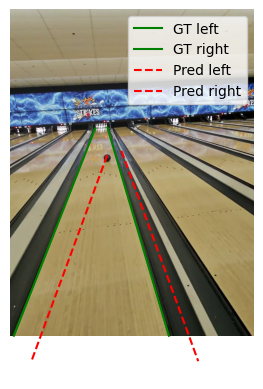

In [112]:
import random

model.load_state_dict(torch.load("lane_regressor_latest.pt", map_location=device))
model.eval()

i = random.randrange(len(ds))
img, gt = ds[i]
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device)).cpu()[0]

img_np = img.permute(1, 2, 0).numpy()
h, w = img_np.shape[:2]

gt_pts = gt.numpy().copy()
pred_pts = pred.numpy().copy()


gt_pts[:,0] *= w
gt_pts[:,1] *= h
pred_pts[:,0] *= w
pred_pts[:,1] *= h

plt.imshow(img_np)
plt.plot(gt_pts[0:2,0], gt_pts[0:2,1], "g-", label="GT left")
plt.plot(gt_pts[2:4,0], gt_pts[2:4,1], "g-", label="GT right")
plt.plot(pred_pts[0:2,0], pred_pts[0:2,1], "r--", label="Pred left")
plt.plot(pred_pts[2:4,0], pred_pts[2:4,1], "r--", label="Pred right")
plt.legend()
plt.axis("off")
plt.show()
